In [61]:
import polars as pl
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import logging
from datetime import datetime
import pandas as pd
from utils import GetDateTimeAsFileName

warnings.filterwarnings("ignore")
commission = 10 / 10000.0
START_CASH = 100000
TRADE_RANK_NUM = 20

In [62]:
LOG_NAME = f'log/factor_backtest_eval_{GetDateTimeAsFileName()}.log'

logger = logging.getLogger()
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

LOG_LEVEL = logging.DEBUG
logging.basicConfig(filename=LOG_NAME, level = LOG_LEVEL, format='%(asctime)s - %(levelname)s - %(message)s')

logger.setLevel(LOG_LEVEL)

print(f"Logging configured. Log file: {LOG_NAME}")

Logging configured. Log file: log/factor_backtest_eval_1109_2155.log


In [63]:
pl.Config.set_tbl_rows(TRADE_RANK_NUM)
logger.info(f"TRADE_RANK_NUM: {TRADE_RANK_NUM}")

ROLLING_DAY = 600
LINEAR_INPUT_FILE = f'data/predictions.parquet'
logger.info(f'LINEAR_INPUT_FILE {LINEAR_INPUT_FILE }')

In [64]:
LONG_TRADE_RANK_RATIO = 1.0
SHORT_TRADE_RANK_RATIO = 0.5
logger.info (f'LONG_TRADE_RANK_RATIO: {LONG_TRADE_RANK_RATIO}, SHORT_TRADE_RANK_RATIO: {SHORT_TRADE_RANK_RATIO}')

DYNAMIC_POS_SCALE = 0
# 未来n天的平均收益率阈值，用来判断是否需要让多空仓位不平衡
POS_RET_THRESHOLD = 3.0
logger.info (f'DYNAMIC_POS_SCALE: {DYNAMIC_POS_SCALE} === threshold: {POS_RET_THRESHOLD}')

In [65]:
def AnalysePnLTrace(pnl, annual_risk_free_rate=0.03, trading_days_per_year=365):
    """
    Analyze the PnL trace to compute various financial metrics.

    Parameters:
        pnl (list or numpy.array): A series of net asset values or account balances over time.
        annual_risk_free_rate (float): The annual risk-free rate, default is 3% (0.03).
        trading_days_per_year (int): The number of trading days per year, default is 252.

    Returns:
        dict: A dictionary with keys as metric names and values as metric values.
    """
    if not isinstance(pnl, np.ndarray):
        pnl = np.array(pnl)

    # Calculate final return
    final_return = (pnl[-1] / pnl[0] - 1) * 100  # in percentage

    # Calculate daily returns
    daily_returns = pnl[1:] / pnl[:-1] - 1

    # Calculate Sharpe Ratio
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1 / trading_days_per_year) - 1
    excess_returns = daily_returns - daily_risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(trading_days_per_year)

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumprod(1 + daily_returns)  # cumulative product of returns
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.min(drawdown)  # most negative value

    # Calculate Volatility (annualized standard deviation of daily returns)
    volatility = np.std(daily_returns) * np.sqrt(trading_days_per_year)

    # Calculate Average Daily Return
    average_daily_return = np.mean(daily_returns)

    # Compile all metrics into a dictionary
    metrics = {
        'sharpe_ratio': sharpe_ratio,
        'final_return_pct(%)': final_return,
        'max_drawdown(%)': max_drawdown * 100.0,
        'volatility': volatility,
        'average_daily_return': average_daily_return
    }

    return metrics

In [66]:
def GetTradeableSymbolList (current_factors, input_ret, current_open_time_when_open_pos) -> list:
    # 找出所有因子值不是NaN的symbol
    non_nan_cols_factors = [
        col
        for col in current_factors.columns
        if (
            current_factors[col].null_count() == 0
            and current_factors[col].is_nan().sum() == 0
        )
    ]

    return non_nan_cols_factors # temp for test

In [67]:
def GetSinglePnL(
    all_time_hist_data,
    result_hour,
    compound_column_name,
    group_num=20,
    long_factor_combination_list=[1, 2, 3],
    update_position_time=1,
    leverage=1,
    trade_with_rank=0,
):
    logger.info(f"start get SinglePnl: {result_hour}")
    FACTOR_NAME = compound_column_name + f"_{update_position_time}day"

    # future_sharp = future_ret / realized_volatility
    # use it for debug
    fut_sharp = compound_column_name + f"_{update_position_time}day_sharp"
    result_hour = result_hour.with_columns(
        (pl.col(FACTOR_NAME) / pl.col("close_price_volatility")).alias(fut_sharp)
    )

    FUT_N_DAY_RET_COL_NAME = f"open_price_fut_{update_position_time}day_ret"
    future_n_day_open_ret = (
        result_hour[["open_time", "symbol", FUT_N_DAY_RET_COL_NAME]]
        .pivot(index="open_time", columns="symbol", values=FUT_N_DAY_RET_COL_NAME)
        .sort("open_time")
    )


    # 默认情况，做多做空的总金额，是50比50
    # 偶尔会改成 60比 40
    long_scale = (
        result_hour[["close_time", "symbol", f'long_value_scale_{update_position_time}day']]
        .pivot(index="close_time", columns="symbol", values = f'long_value_scale_{update_position_time}day')
        .sort("close_time")
    )

    # 因为此时的因子值是在close_time的时候计算的，所以要用close_time
    factors = (
        result_hour[["close_time", "symbol", FACTOR_NAME]]
        .pivot(index="close_time", columns="symbol", values=FACTOR_NAME)
        .sort("close_time")
    )

    # 每根k线的开盘价
    open_df = (
        result_hour[["open_time", "symbol", "open"]]
        .pivot(index="open_time", columns="symbol", values="open")
        .sort("open_time")
    )

    # all_time_close_return = (
    #     all_time_hist_data[["close_time", "symbol", "close_return"]]
    #     .pivot(index="close_time", columns="symbol", values="close_return")
    #     .sort("close_time")
    # )

    # relalized volatility for OPEN price
    # volatility_open_price = (
    #     result_hour[["open_time", "symbol", "open_price_volatility"]]
    #     .pivot(index="open_time", columns="symbol", values="open_price_volatility")
    #     .sort("open_time")
    # )

    # relalized volatility for CLOSE price
    # volatility_close_price = (
    #     result_hour[["close_time", "symbol", "close_price_volatility"]]
    #     .pivot(index="close_time", columns="symbol", values="close_price_volatility")
    #     .sort("close_time")
    # )

    # # position factor
    # position_factor = (
    #     all_time_hist_data[["close_time", "symbol", "pos_signals"]]
    #     .pivot(index="close_time", columns="symbol", values="pos_signals")
    #     .sort("close_time")
    # )

    columns = future_n_day_open_ret.columns[1:]  # means all symbols
    all_symbols = columns

    # 在每一根k线走完的时候计算因子值，然后调仓
    # 所以要遍历每一个close_time，进行调仓
    factors.sort("close_time")
    time_array = factors["close_time"].to_numpy()

    time_array = time_array[:-1]  # the last line doesn't have next day return

    today_pnl = 1
    pnl = []
    long_stocks = []
    short_stocks = []
    cash = START_CASH
    cur_position = pl.DataFrame(
        {col: [value] for col, value in zip(columns, [0] * len(columns))}
    )
    next_step_position = pl.DataFrame(
        {col: [value] for col, value in zip(columns, [0] * len(columns))}
    )

    # print (f'update_position_time: {update_position_time}')

    # 用日线数据的时候，每一行是一天；小时数据的时候，每24行是一天
    update_row_index = update_position_time
    fut_avg_long_pos_ret, fut_avg_short_pos_ret = 0, 0

    # used to count the PnL for current pos & stop loss early
    cur_pos_open_price: pl.DataFrame = None
    cur_hold_long_symbol_list = []
    cur_hold_short_symbol_list = []

    for i, cur_close_time in enumerate(time_array):

        # 用下一根k线的开盘价作为调仓价格，open_time是1ms后
        time_delta: np.timedelta64 = np.timedelta64(1, "ms")

        next_bar_open_time = cur_close_time + time_delta
        all_open_price_when_open_pos = open_df.filter(
            pl.col("open_time") == next_bar_open_time
        ).drop("open_time")

        # for debug and check pnl
        # 计算 {update_position_time} 天后的平仓时间(也是在开盘价平仓，所以是open_time)
        bar_open_time_to_close_pos = next_bar_open_time + np.timedelta64(
            update_position_time, "D"
        )

        logger.debug(
            f"cur time: {cur_close_time} == next bar open time: {next_bar_open_time} == close pos time: {bar_open_time_to_close_pos}"
        )

        if i % update_row_index == 0:
            # Before update the position, calc the total cash+position value

            assert all_open_price_when_open_pos.columns == cur_position.columns

            # 选取当前时间点的数据
            current_factors = factors.filter(
                pl.col("close_time") == cur_close_time
            ).drop("close_time")

            tradeable_symbol_list = GetTradeableSymbolList(
                current_factors, future_n_day_open_ret, bar_open_time_to_close_pos
            )

            if trade_with_rank == 0 and len(tradeable_symbol_list) < group_num:
                # 如果可以交易的symbol数目小于组数，那么无法进行交易
                pnl.append(today_pnl)
                continue

            # 把所有可以交易的symbol的因子值找出来
            long_factors = current_factors.select(tradeable_symbol_list).melt(
                id_vars=[],
                value_vars=tradeable_symbol_list,
                variable_name="symbol",
                value_name="factor_value",
            )

            assert len (tradeable_symbol_list) > 0 and long_factors.shape[0] > 0, f'no tradeable symbol at {cur_close_time}'
            assert (
                long_factors["factor_value"].is_null().sum() == 0
            ), "factor_value column contains null values"
            assert (
                long_factors["factor_value"].is_nan().sum() == 0
            ), "factor_value column contains NaN values"

            # 对全部symbol按照因子值排序
            sorted_long_factors = long_factors.sort("factor_value")

            # 对全部symbol进行分组，计算每个组的symbol数目
            group_size = max(
                int(sorted_long_factors.height / group_num), 1
            )  # 避免除以零

            if trade_with_rank != 0:
                # 基于排序的名次交易（只做多前xx个），而不是基于分组交易
                rank_labels = (pl.arange(0, sorted_long_factors.height)).cast(pl.UInt32)
                sorted_long_factors = sorted_long_factors.with_columns(
                    rank_labels.alias("rank")
                )

                # Create Reverse Rank label
                max_rank = sorted_long_factors.height - 1
                reverse_rank_labels = (max_rank - rank_labels).cast(pl.UInt32)
                sorted_long_factors = sorted_long_factors.with_columns(
                    reverse_rank_labels.alias("reverse_rank")
                )
            else:
                # 创建组标签
                # 使用 pl.arange 生成行索引，然后除以每组大小，并取整获得组号
                group_labels = (
                    pl.arange(0, sorted_long_factors.height) / group_size
                ).cast(pl.UInt32)

                # 将组标签列添加到 DataFrame
                sorted_long_factors = sorted_long_factors.with_columns(
                    group_labels.alias("group")
                )

            logger.debug(f"sorted_long_factors: {sorted_long_factors}")

            # temp for verify the production
            symbol_list = sorted_long_factors['symbol'].to_list()
            # logger.debug (f'long: {symbol_list[-22:]}')
            # logger.debug (f'short: {symbol_list[:12]}')

            if trade_with_rank != 0:
                # 如果 trade_with_rank 不为 0，那么使用 rank 进行交易
                # trade_with_rank 为正数时，做多排名靠前的股票，同时做空排名靠后的股票
                # 为负数时，做空排名靠前的股票, 同时做多排名靠后的股票

                # 有可能 2 * trade_with_rank 的绝对值大于 sorted_long_factors.height(全部symbol数目)
                cur_trade_num = min(
                    abs(trade_with_rank), sorted_long_factors.height / 2
                )

                assert (
                    LONG_TRADE_RANK_RATIO + SHORT_TRADE_RANK_RATIO
                ) * cur_trade_num <= sorted_long_factors.height, (
                    "total of long & short should not exceed total symbol number"
                )

                cur_rank_column = "rank" if trade_with_rank > 0 else "reverse_rank"
                long_stock_set = sorted_long_factors.filter(
                    pl.col(cur_rank_column) < cur_trade_num * LONG_TRADE_RANK_RATIO
                )
                short_stock_set = sorted_long_factors.filter(
                    pl.col(cur_rank_column)
                    > sorted_long_factors.height
                    - 1
                    - cur_trade_num * SHORT_TRADE_RANK_RATIO
                )
            else:
                # 计算做空组的索引
                short_combination_list = [
                    group_num - 1 - x for x in long_factor_combination_list
                ]

                # 提取做多的股票集合
                long_stock_set = sorted_long_factors.filter(
                    pl.col("group").is_in(long_factor_combination_list)
                )
                # 提取做空的股票集合
                short_stock_set = sorted_long_factors.filter(
                    pl.col("group").is_in(short_combination_list)
                )

            long_symbol_list: list = (
                long_stock_set.select("symbol").unique().to_pandas().squeeze().to_list()
            )
            short_symbol_list: list = (
                short_stock_set.select("symbol")
                .unique()
                .to_pandas()
                .squeeze()
                .to_list()
            )

            # 改为每次开仓都使用固定值
            each_side_symbol_total_val = 100000.0  # 单边的总价值
            long_value_ratio = 1.0
            short_value_ratio = 1.0

            if DYNAMIC_POS_SCALE:
                if (
                    fut_avg_long_pos_ret > POS_RET_THRESHOLD
                    and fut_avg_short_pos_ret > POS_RET_THRESHOLD
                ):
                    long_value_ratio, short_value_ratio = 1.2, 0.8
                elif (
                    fut_avg_long_pos_ret < -POS_RET_THRESHOLD
                    and fut_avg_short_pos_ret < -POS_RET_THRESHOLD
                ):
                    long_value_ratio, short_value_ratio = 0.8, 1.2
            
            cur_long_scale = long_scale.filter(pl.col("close_time") == cur_close_time)[long_symbol_list[0]].to_numpy()[0]
            # assert (cur_long_scale == long_value_ratio), f'{cur_close_time}=====cur_long_scale: {cur_long_scale} not match == long_value_ratio: {long_value_ratio}'

            if cur_long_scale != long_value_ratio:
                logger.warning (f'{cur_close_time}=====cur_long_scale: {cur_long_scale} not match == long_value_ratio: {long_value_ratio}')

            assert (
                long_value_ratio + short_value_ratio == 2.0
            ), "sum ratio should be 2.0"

            logger.info (f'cur close time: {cur_close_time} == long_value_ratio: {long_value_ratio} == short_value_ratio: {short_value_ratio} --- {cur_long_scale}')

            total_long_pos_value = each_side_symbol_total_val * long_value_ratio
            total_short_pos_value = -each_side_symbol_total_val * short_value_ratio

            # Initialize long_symbol_pos_ratio_dict
            long_symbol_pos_ratio_dict = {
                symbol: 1.0 / len(long_symbol_list) for symbol in long_symbol_list
            }
            short_symbol_pos_ratio_dict = {
                symbol: 1.0 / len(short_symbol_list) for symbol in short_symbol_list
            }


            # for future calc position ratio
            mean_expected_ret = sorted_long_factors['factor_value'].drop_nans().drop_nulls().mean()
            logger.debug (f'mean expected ret (mean factor): {mean_expected_ret}')

            # 用 next_step_value 计算调仓后，每个symbol的市场价值
            next_step_value = pl.DataFrame({col: [0] for col in all_symbols})
            for symbol in long_symbol_list:
                assert symbol in next_step_value.columns
                next_step_value = next_step_value.with_columns(
                    pl.lit(
                        total_long_pos_value * long_symbol_pos_ratio_dict[symbol]
                    ).alias(symbol)
                )

            # Set short positions
            for symbol in short_symbol_list:
                assert symbol in next_step_value.columns
                next_step_value = next_step_value.with_columns(
                    pl.lit(
                        total_short_pos_value * short_symbol_pos_ratio_dict[symbol]
                    ).alias(symbol)
                )

            # 用调仓后的市场价值, 除以每个symbol的开仓价,得到每个symbol的调仓后的仓位
            next_step_position = next_step_value / all_open_price_when_open_pos

            logger.debug(f"begin to update pos: =========")
            logger.debug(f"next_step_value: {next_step_value}")
            logger.debug(
                f"all_open_price_when_open_pos: {all_open_price_when_open_pos}"
            )

            cur_pos_open_price = all_open_price_when_open_pos.clone()

            # 对于此时没上市的symbol, all_open_price_when_open_pos is None, so the next_step_position will be null
            # then diff_position will be null, which will lead to PnL calc wrong
            # 所以提前把null填充0
            next_step_position = next_step_position.fill_null(0)

            # 需要调仓的仓位变动, 对于每个symbol，相当于是卖出 diff_position个，所以累加到cash里
            diff_position = cur_position - next_step_position
            realized_pnl = diff_position * all_open_price_when_open_pos

            def sum_row(df: pl.DataFrame) -> float:
                return df.select(
                    pl.sum_horizontal(
                        # pl.all().filter(pl.col.is_numeric())
                        pl.all()
                    ).fill_null(0)
                ).item()

            # new pl version
            cash += sum_row(diff_position * all_open_price_when_open_pos)

            abs_diff_position = diff_position.select(
                [pl.col(column).sum().abs() for column in diff_position.columns]
            )
            abs_diff_trading_value = sum_row(
                abs_diff_position * all_open_price_when_open_pos
            )
            # 调仓交易额的手续费
            cash -= abs_diff_trading_value * commission

            cur_position = next_step_position.clone()  # 完成调仓
            cur_hold_long_symbol_list = long_symbol_list
            cur_hold_short_symbol_list = short_symbol_list
            logger.debug(
                f"update position: {cur_close_time} === diff_trading_value: {abs_diff_trading_value} == cash: {cash} "
            )

        latest_pnl = cash + sum_row(all_open_price_when_open_pos * cur_position)

        if len(pnl) > 0:
            logger.info(
                f"pnl: {cur_close_time} {latest_pnl} === {(latest_pnl / pnl[-1] - 1) * 100:.3f}%"
            )
        pnl.append(latest_pnl)
    return pnl, AnalysePnLTrace(pnl), " "
    pnl_series = pl.Series("PnL", pnl)
    return pnl, factor_stats(pnl=pnl_series)
    # Convert pnl list to a polars Series

In [68]:
def GetRollingPnL(
    all_time_hist_data,
    result_hour,
    compound_column_name,
    group_num=20,
    long_factor_combination_list=[1, 2, 3],
    update_position_time=1,
    leverage=1,
    trade_with_rank = 0
):
    unique_time = result_hour.select(pl.col("open_time").unique()).sort("open_time")
    sum_pnl = np.zeros(unique_time.shape[0] - 1) # the last day doesn't have pnl
    stats_pnl = np.zeros(unique_time.shape[0])
    # for i in range (1, 2):
    for i in range(update_position_time):
        cur_unique_time = unique_time.slice(i)

        cur_result_hour = result_hour.filter(pl.col("open_time").is_in(cur_unique_time))

        # print (f'slice {i} == {cur_result_hour.shape}')
        cur_pnl, _, __ = GetSinglePnL(
            all_time_hist_data,
            cur_result_hour,
            compound_column_name,
            group_num=group_num,
            long_factor_combination_list=long_factor_combination_list,
            update_position_time=update_position_time,
            leverage=leverage,
            trade_with_rank=trade_with_rank
        )
        cur_pnl = np.insert(cur_pnl, 0, [START_CASH] * i)
        print (f'Rolling i {i} ===== cur pnl {len (cur_pnl)} == sum_pnl: {len (sum_pnl)} ==== unique time shape: {unique_time.shape}')
        print (AnalysePnLTrace(cur_pnl))
        assert len(cur_pnl) == len(sum_pnl)
        sum_pnl += cur_pnl

    sum_pnl /= update_position_time # 多个组合进行平均，是平均收益
    stats_pnl = stats_pnl - (START_CASH * (update_position_time - 1))

    pnl_series = pl.Series("PnL", stats_pnl)
    # return sum_pnl, AnalysePnLTrace(sum_pnl), factor_stats(pnl=pnl_series)
    return sum_pnl, AnalysePnLTrace(sum_pnl), ' '
    # return sum_pnl, AnalysePnLTrace(sum_pnl)

In [69]:
from enum import Enum

class Metric(Enum):
    SHARPE_RATIO = 'sharpe_ratio'
    FINAL_RETURN_PCT = 'final_return_pct'
    MAX_DRAWDOWN = 'max_drawdown'
    VOLATILITY = 'volatility'
    AVERAGE_DAILY_RETURN = 'average_daily_return'


In [70]:
def AddHourGroupColumn (input_df: pl.DataFrame):
    # add hour_group
    input_df = input_df.with_columns (
        pl.col ('open_time').dt.hour().alias ('hour_group')
    )

    # Move the 'hour_group' column to the front
    input_df = input_df.select(
        pl.col('hour_group'),
        pl.all().exclude('hour_group')
    )
    return input_df

In [71]:
def AddReturnFactor(input_df: pl.DataFrame) -> pl.DataFrame:
    # 千万注意，这里是计算此时刻相对于前一时刻的return，不能使用未来信息 -> shift(1)是整体往下移动
    input_df = input_df.with_columns(
        ((pl.col("close") / pl.col("close").shift(1) - 1) * 100)
        .over("symbol")  # Applying the function over each symbol group
        .alias("close_return")
    )
    return input_df


history_data_path = 'data/all_data_1d.parquet'
all_time_hist_data = pl.read_parquet(history_data_path)
all_time_hist_data = all_time_hist_data.filter (pl.col ('open_time') >= datetime(2022, 1, 1).timestamp() * 1000)
all_time_hist_data = AddReturnFactor(all_time_hist_data)
all_time_hist_data = all_time_hist_data.filter(pl.col("close_return").is_not_null())
all_time_hist_data = all_time_hist_data.sort ('open_time')
all_time_hist_data

symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,close_return
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64
"""COTIUSDT""",1640995200000,0.3547,0.38884,0.35432,0.38779,1.09002281e8,1641081599999,4.0735e7,165817,5.4916899e7,2.0517e7,810.518901
"""LRCUSDT""",1640995200000,2.08502,2.11985,2.03739,2.08785,3.7938582e7,1641081599999,7.8577e7,259104,1.8369514e7,3.8056e7,400.563414
"""SUSHIUSDT""",1640995200000,9.424,9.5,9.02,9.135,4.6566268e7,1641081599999,4.3012e8,697560,2.2431971e7,2.0727e8,633.204912
"""ADAUSDT""",1640995200000,1.3077,1.3789,1.3054,1.3781,2.44489059e8,1641081599999,3.2651e8,493309,1.21009878e8,1.6166e8,332.54865
"""PEOPLEUSDT""",1640995200000,0.11779,0.1262,0.11779,0.12495,4.67555417e8,1641081599999,5.7266e7,201875,2.22321678e8,2.7249e7,862.634823
"""ALICEUSDT""",1640995200000,12.487,13.374,12.482,13.364,1.0326342e7,1641081599999,1.3489e8,326532,4985999.8,6.5131e7,1384.888889
"""CELRUSDT""",1640995200000,0.07311,0.0791,0.07309,0.07896,8.27422507e8,1641081599999,6.3280e7,219925,4.03239281e8,3.0833e7,409.419355
"""DOTUSDT""",1640995200000,26.65,28.62,26.643,28.579,1.4988398e7,1641081599999,4.1274e8,660103,7392532.9,2.0371e8,563.085847
"""UNFIUSDT""",1640995200000,7.915,8.462,7.906,8.431,1495601.3,1641081599999,1.2275e7,83215,718121.7,5.8943e6,-8.199042


In [72]:
# from position_factor import CalcPositionFactor
# all_time_hist_data = CalcPositionFactor (all_time_hist_data)

# no need the pos_signals for now, so use all zero
all_time_hist_data = all_time_hist_data.with_columns (
    pl.lit (0).alias ('pos_signals')
)


In [73]:
all_time_hist_data = pl.read_parquet("data/all_data_1d.parquet")
result_hour = pl.read_parquet("data/predictions.parquet")
result_hour = result_hour.with_columns(
        pl.from_epoch(pl.col("open_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("open_time"),
        pl.from_epoch(pl.col("close_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("close_time"),
    )
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 7))  # 周日开仓 bad
result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 8))  # 周一开仓
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 9))  # 周二开仓 bad
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 10))  # 周三开仓
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 11))  # 周四开仓
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 12))  # 周五开仓
# result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 13))  # 周六开仓

# pnl, metrics, fac_stat_output= GetSinglePnL(
pnl, metrics, fac_stat_output = GetRollingPnL(
    all_time_hist_data=all_time_hist_data,
    result_hour=result_hour.filter(pl.col("linear_compound_factor_7day").is_not_null()),
    compound_column_name="linear_compound_factor",
    group_num=10,
    long_factor_combination_list=[9],
    update_position_time=7,
    trade_with_rank=-20
)


Rolling i 0 ===== cur pnl 658 == sum_pnl: 658 ==== unique time shape: (659, 1)
{'sharpe_ratio': 1.1913599053194062, 'final_return_pct(%)': 97.06572839748895, 'max_drawdown(%)': -19.5253978833243, 'volatility': 0.3404396269009799, 'average_daily_return': 0.0011921811529483144}
Rolling i 1 ===== cur pnl 658 == sum_pnl: 658 ==== unique time shape: (659, 1)
{'sharpe_ratio': 0.2382173041667601, 'final_return_pct(%)': 8.345512969158175, 'max_drawdown(%)': -29.40965301822353, 'volatility': 0.40162223938726427, 'average_daily_return': 0.00034310511319085097}
Rolling i 2 ===== cur pnl 658 == sum_pnl: 658 ==== unique time shape: (659, 1)
{'sharpe_ratio': 1.1009675801124306, 'final_return_pct(%)': 92.15057821537714, 'max_drawdown(%)': -31.265819879188587, 'volatility': 0.362747783338527, 'average_daily_return': 0.0011751604064870567}
Rolling i 3 ===== cur pnl 658 == sum_pnl: 658 ==== unique time shape: (659, 1)
{'sharpe_ratio': 1.7571590230800191, 'final_return_pct(%)': 135.00335555151798, 'max_d

In [74]:
metrics

{'sharpe_ratio': 1.1658585983613212,
 'final_return_pct(%)': 73.22055808160475,
 'max_drawdown(%)': -16.887648097250388,
 'volatility': 0.2672073574002137,
 'average_daily_return': 0.0009344821762324797}

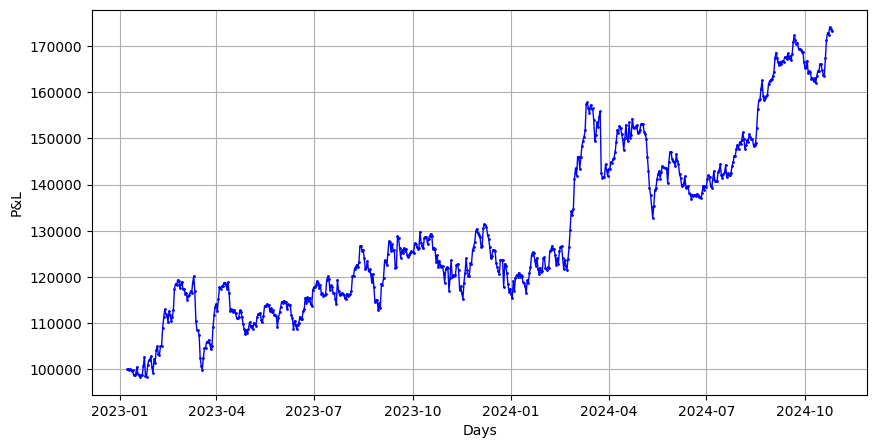

In [75]:
time_array = result_hour['open_time'].unique().sort().to_numpy()
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.plot(time_array[0:len (pnl)], pnl, marker='o', linestyle='-', color='b', linewidth=1, markersize=1)  # 'o' is the marker, line-style is solid by default
plt.xlabel('Days')
plt.ylabel('P&L')
plt.grid(True)  # Turn on the grid for better readability of the plot
plt.show()